### **本节介绍序列模型(以单步预测引入)**

In [11]:
# 导入包
import torch
import numpy as np
from d2l import torch as d2l
import matplotlib.pyplot as plt
from net_frame import *
from torch import nn

torch.Size([1000])
torch.Size([1000])


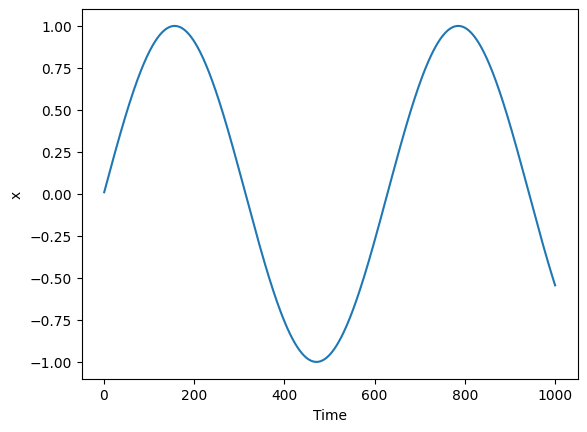

In [12]:
# 生成正弦数据
T = 1000
time = torch.arange(1,T + 1,dtype = torch.float32)
print(time.shape)
x = torch.sin(0.01 * time)
print(x.shape)
plt.plot(time,x)
plt.xlabel('Time')
plt.ylabel('x')
plt.show()

我们的序列模型是想用前面的序列推出后面的序列的x，我们可以截取前面的time:1~600来作为训练集，后面400则为测试集

In [13]:
# 构建数据集
tau = 4
features = torch.zeros((T - tau,tau)) # 以4个点为一连续序列作为推断标准
for i in range(tau):
    features[:,i] = x[i:i + T - tau]
# labels = x[tau:] # 错误，记得y_pred.shape == label.shape
labels = x[tau:].reshape(-1,1)

In [14]:
print(features.shape,labels.shape)

torch.Size([996, 4]) torch.Size([996, 1])


In [15]:
# 取数据集中的前600项为训练集
batch_size = 16
n_train = 600
train_iter = load_array((features[:n_train],labels[:n_train]),batch_size = batch_size,
                        is_train = True)

In [16]:
# 搭建网络

# 网络初始化
def init_weight(m):
    if (type(m) == nn.Linear):
        nn.init.xavier_uniform_(m.weight)

# 获取网络：一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weight)
    return net

loss_fn = nn.MSELoss(reduction='none') # 回归问题用平方误差

In [17]:
# 模型训练函数
def train(net,train_iter,loss_fn,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        loss_save = 0 
        net.train()
        for x,y in train_iter:
            trainer.zero_grad()
            pred = net(x)
            loss = loss_fn(pred,y) # loss.shape = [len(x),1]
            loss.sum().backward() # 求和再反向传播，强调batch_size一起最优，而非一个数据单独最优
            trainer.step()
            with torch.no_grad():
                loss_save += loss.sum().item()
        print(f"epoch {epoch + 1} finished!","\n",f"loss:{loss_save/len(train_iter)/batch_size}") # 输出一个数据的损失
    return net

In [18]:
pred_net = train(get_net(),train_iter,loss_fn,epochs = 5,lr = 0.01)

epoch 1 finished! 
 loss:0.1851618293868868
epoch 2 finished! 
 loss:0.007750409955501948
epoch 3 finished! 
 loss:0.004042283950471564
epoch 4 finished! 
 loss:0.0023817503487838336
epoch 5 finished! 
 loss:0.0017002293806351525


In [19]:
# 错误示范
# x = torch.tensor([1,2,3,4,5],dtype = torch.float32)
# y = x.clone().reshape(-1,1)
# print(x.shape,y.shape)
# print(loss_fn(x,y)) # 广播了再求loss，显然错误

torch.Size([996, 1]) torch.Size([1000])
torch.Size([996])


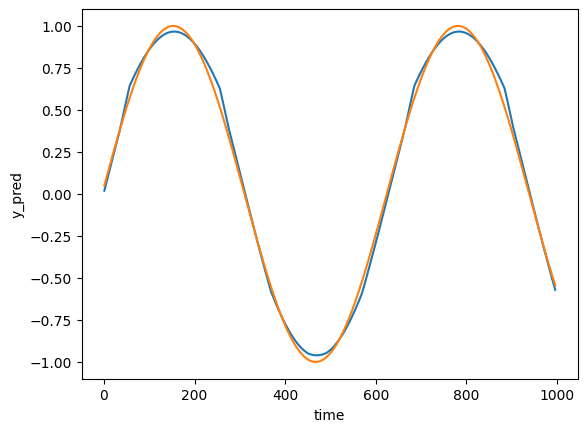

tensor([0.0189, 0.0296, 0.0403, 0.0509, 0.0616, 0.0723, 0.0829, 0.0935, 0.1042,
        0.1148], grad_fn=<SliceBackward0>)
tensor([0.0500, 0.0600, 0.0699, 0.0799, 0.0899, 0.0998, 0.1098, 0.1197, 0.1296,
        0.1395])


In [20]:
# 检测结果
y_pred = pred_net(features) # 预测的结果是单步的后面，即x_5 = net(x_1,x_2,x_3,x_4)
print(y_pred.shape,time.shape)
y_pred = y_pred.squeeze(1)
print(y_pred.shape)
plt.plot(time[0:996],y_pred.detach())
plt.plot(time[0:996],x[tau:])
plt.xlabel('time')
plt.ylabel('y_pred')
plt.show()
print(y_pred[:10])
print(x[tau:tau + 10])

**利用net预测的下一步拼接成的函数形状符合预期，但是实际的结果似乎与原结果有偏差，即整体滞后了!**